Epoch 1/50, Loss: 0.7906811789554709
Epoch 2/50, Loss: 0.44861209914362166
Epoch 3/50, Loss: 0.3444030827130465
Epoch 4/50, Loss: 0.27451662072254457
Epoch 5/50, Loss: 0.19827147874542894
Epoch 6/50, Loss: 0.15694567826268374
Epoch 7/50, Loss: 0.1419673021444503
Epoch 8/50, Loss: 0.12688946027500445
Epoch 9/50, Loss: 0.09382564337814556
Epoch 10/50, Loss: 0.06769000623676488
Epoch 11/50, Loss: 0.04180325073128402
Epoch 12/50, Loss: 0.0328242709122338
Epoch 13/50, Loss: 0.023042264173700994
Epoch 14/50, Loss: 0.014954571659087807
Epoch 15/50, Loss: 0.013586731461862869
Epoch 16/50, Loss: 0.008202354594729566
Epoch 17/50, Loss: 0.005547238781411365
Epoch 18/50, Loss: 0.004864445197745227
Epoch 19/50, Loss: 0.0039166919163750105
Epoch 20/50, Loss: 0.0034111032935256577
Epoch 21/50, Loss: 0.0024664832705799627
Epoch 22/50, Loss: 0.0023267901647533802
Epoch 23/50, Loss: 0.0021782871693550774
Epoch 24/50, Loss: 0.002009876618296189
Epoch 25/50, Loss: 0.001889707705905654
Epoch 26/50, Loss: 0

<ipython-input-2-b48a26edcb59>:118: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_checkpoint.pth'))


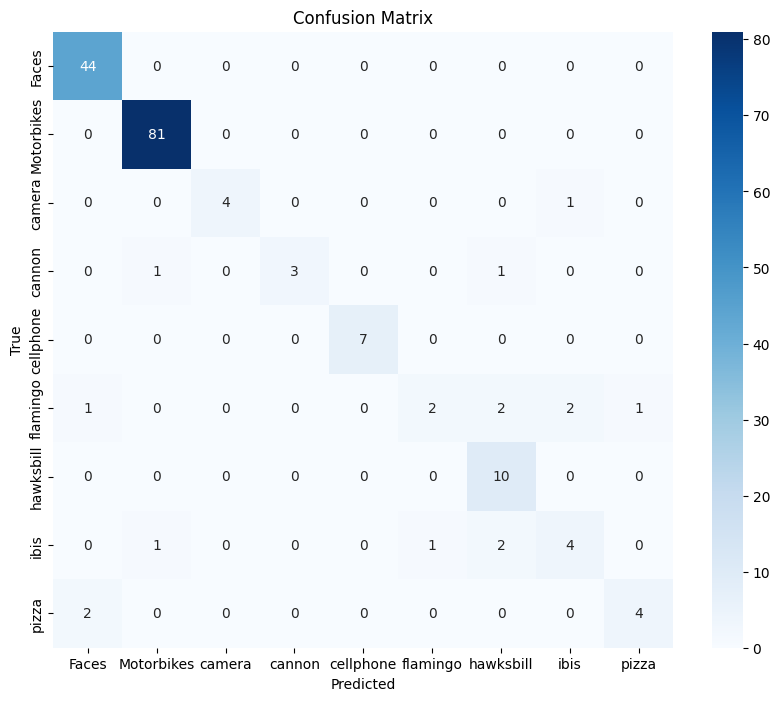

Accuracy: 0.9138
F1 Score: 0.9040
AUC Score: 0.9895


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import zipfile
import os
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri Setini Açma
# İlk olarak, veri setinin bulunduğu zip dosyasını açıyoruz.
# Zip dosyasını açarak içeriği '/content/CaltechTinySplit' dizinine çıkartıyoruz.
with zipfile.ZipFile('/content/CaltechTinySplit.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/CaltechTinySplit')

# Çıkarılan veri setlerinin her birine ait dizin yolları
train_dir = '/content/CaltechTinySplit/CaltechTinySplit/train'  # Eğitim verisi
test_dir = '/content/CaltechTinySplit/CaltechTinySplit/test'    # Test verisi
val_dir = '/content/CaltechTinySplit/CaltechTinySplit/val'      # Doğrulama verisi

# 2. Dönüştürme Fonksiyonları Tanımlama
# Veriyi modelimize uygun hale getirebilmek için bazı ön işlemler (transformasyonlar) yapıyoruz.
# Resimleri yeniden boyutlandırıyoruz (128x128), yatayda rastgele çeviriyoruz, tensor'e dönüştürüyoruz
# ve son olarak normalize ediyoruz (piksel değerlerini -1 ile 1 arasında).
transform = transforms.Compose([
    transforms.Resize((128, 128)),           # Resmi 128x128 boyutlarına getiriyoruz.
    transforms.RandomHorizontalFlip(),       # Resimleri yatayda rastgele çeviriyoruz.
    transforms.ToTensor(),                   # Resimleri tensor formatına çeviriyoruz.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize ediyoruz, ortalama 0.5 ve standart sapma 0.5.
])

# 3. Veri Setlerini Yükleme
# ImageFolder kullanarak eğitim, test ve doğrulama veri setlerini yüklüyoruz.
train_data = datasets.ImageFolder(root=train_dir, transform=transform)
test_data = datasets.ImageFolder(root=test_dir, transform=transform)
val_data = datasets.ImageFolder(root=val_dir, transform=transform)

# Veri setlerini DataLoader ile yükleyip, her bir batch için veri çekiyoruz.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle=False)

# 4. Gish Aktivasyon Fonksiyonu
# Modelde kullanılacak Gish aktivasyon fonksiyonunu tanımlıyoruz. Bu fonksiyon,
# her bir giriş için `x * log(2 - exp(-exp(x)))` hesaplar.
class GishActivation(nn.Module):
    def __init__(self):
        super(GishActivation, self).__init__()

    def forward(self, x):
        return x * torch.log(2 - torch.exp(-torch.exp(x)))

# 5. CNN Modelini Tanımlama
# Modelin yapısını tanımlıyoruz. CNN modelimizde 2 konvolüsyon katmanı,
# bir max pooling katmanı ve 2 tam bağlantılı katman bulunuyor.
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 3 kanal (RGB) giriş, 32 kanal çıkış
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 32 kanal giriş, 64 kanal çıkış
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        self.fc1 = nn.Linear(64 * 32 * 32, 512)  # Tam bağlantılı katman (512 nöron)
        self.fc2 = nn.Linear(512, len(train_data.classes))  # Çıkış katmanı (sınıf sayısı kadar çıkış)
        self.gish = GishActivation()  # Gish aktivasyon fonksiyonu

    def forward(self, x):
        # Konvolüsyon katmanları ve aktivasyonlar
        x = self.pool(self.gish(self.conv1(x)))
        x = self.pool(self.gish(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)  # Katmanlardan çıkan veriyi düzleştiriyoruz
        x = self.gish(self.fc1(x))     # Tam bağlantılı katman 1
        x = self.fc2(x)                # Çıkış katmanı
        return x

# Modeli başlatma
model = CNNModel()

# 6. Model Ayarlarını Belirleme
# Öğrenme oranı, optimizer ve loss fonksiyonunu ayarlıyoruz.
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer
criterion = nn.CrossEntropyLoss()  # Çapraz entropi kaybı (çok sınıflı sınıflandırma için)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.3)  # Öğrenme oranı düşürme

# Cihaz kontrolü (GPU kullanımı)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 7. Modeli Eğitme
# Modeli 50 epoch boyunca eğitiyoruz.
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Verileri GPU'ya taşıyoruz

        optimizer.zero_grad()  # Gradyanları sıfırlıyoruz
        outputs = model(images)  # Modelin çıktısını alıyoruz
        loss = criterion(outputs, labels)  # Kayıp hesaplama
        loss.backward()  # Geri yayılım (backpropagation)
        optimizer.step()  # Parametre güncelleme

        running_loss += loss.item()  # Toplam kaybı biriktiriyoruz
    scheduler.step()  # Öğrenme oranını güncelliyoruz

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")  # Epoch başına kaybı yazdırıyoruz

# Modeli Kaydetme
# Modelin eğitim tamamlandıktan sonra parametrelerini kaydediyoruz
torch.save(model.state_dict(), 'model_checkpoint.pth')

# 8. Modeli Yükleme ve Test Etme
# Eğitilen modeli test etmek için yüklüyoruz
model.load_state_dict(torch.load('model_checkpoint.pth'))
model.eval()  # Modeli değerlendirme moduna alıyoruz

# Test seti üzerindeki performansı ölçme
all_preds = []
all_labels = []
all_outputs = []
with torch.no_grad():  # Gradyan hesaplamalarını devre dışı bırakıyoruz
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Verileri GPU'ya taşıyoruz
        outputs = model(images)  # Modelin çıktısını alıyoruz
        _, preds = torch.max(outputs, 1)  # En yüksek olasılığa sahip sınıfı tahmin ediyoruz
        all_preds.extend(preds.cpu().numpy())  # Tahminleri kaydediyoruz
        all_labels.extend(labels.cpu().numpy())  # Gerçek etiketleri kaydediyoruz
        all_outputs.extend(outputs.cpu().numpy())  # Modelin ham çıktıları (logits) kaydediyoruz

# 9. Performans Değerlerini Gösterme
# Confusion Matrix: Tahminlerin doğru ve yanlış sınıflandırmalarını gösteriyoruz
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy, F-Score ve AUC Skoru Hesaplama
accuracy = accuracy_score(all_labels, all_preds)  # Doğruluk oranını hesaplıyoruz
f_score = f1_score(all_labels, all_preds, average='weighted')  # F1 skorunu hesaplıyoruz (ağırlıklı ortalama)

# Çok sınıflı AUC Skoru Hesaplama
# Etiketleri binary (0 veya 1) formatına çeviriyoruz (one-hot encoding)
all_labels_bin = label_binarize(all_labels, classes=list(range(len(train_data.classes))))

# Softmax fonksiyonu ile her sınıf için olasılıkları elde et
# Modelin çıktıları üzerinde softmax uygulayarak olasılıkları hesaplıyoruz
all_outputs = np.array(all_outputs)
probabilities = np.exp(all_outputs) / np.sum(np.exp(all_outputs), axis=1, keepdims=True)

# AUC skoru hesaplama
auc = roc_auc_score(all_labels_bin, probabilities, average='macro', multi_class='ovr')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f_score:.4f}")
print(f"AUC Score: {auc:.4f}")
